# Lab 1 – Pima Diabetes: KNIME ↔ Python Companion Notebook

This notebook mirrors the main blocks of the KNIME workflow:

1. **Data Preparation** (yellow block)
2. **Decision Tree (Baseline) Model** (green block)
3. **Logistic Regression Model and Feature Importances** (blue block)

The goal is to reproduce in Python what happens in KNIME, and to show how models and predictions can be shared between KNIME and Python.


> **Note**  
> If you run this notebook in a fresh environment (e.g. Google Colab), you may need to install a few packages first.  
> Uncomment and run the cell below once.


In [1]:
# !pip install pandas scikit-learn pypmml matplotlib

The code below imports all required libraries and defines utility functions that will be used in the rest of this notebook.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

try:
    from pypmml import Model as PMMLModel
except ImportError:
    PMMLModel = None

IN_COLAB = "google.colab" in sys.modules


def resolve_data_dir():
    candidate_dirs = [
        ".",                  # same folder as notebook
        "/content",           # Colab root
    ]

    for base in candidate_dirs:
        csv_candidate = os.path.join(base, "diabetes.csv")
        if os.path.exists(csv_candidate):
            print(f"Using data directory: {os.path.abspath(base)}")
            return base

    raise FileNotFoundError(
        "Could not find 'diabetes.csv'. Please place it next to the notebook "
    )

DATA_DIR = resolve_data_dir()

def evaluate_classifier(y_true, y_pred, y_prob=None, positive_label=1, model_name="model"):
    y_true = pd.Series(y_true).astype(str)
    y_pred = pd.Series(y_pred).astype(str)
    pos = str(positive_label)

    print(f"\n=== Evaluation for {model_name} ===")
    print("Label distribution:")
    print("  y_true:")
    print(y_true.value_counts())
    print("\n  y_pred:")
    print(y_pred.value_counts())

    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=["0", pos])

    print(f"\nAccuracy: {acc:.3f}")
    print("\nConfusion matrix (rows=true, cols=pred) [0,1]:")
    print(cm)

    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=3, zero_division=0))

    auc = None
    if y_prob is not None:
        y_true01 = (y_true == pos).astype(int)
        auc = roc_auc_score(y_true01, y_prob)
        print(f"ROC AUC (class {pos} vs others): {auc:.3f}")
    else:
        print("\n[Info] ROC AUC not computed (no probability scores provided).")

    return {"accuracy": acc, "roc_auc": auc, "confusion_matrix": cm}

Using data directory: /Users/theerapatkangsilalai/Documents/GitHub/digitalhealth-ai2025/code/Week01_IntroML


## 1) Data Preparation (matches yellow block)

This section corresponds to:

- **CSV Reader** – load `diabetes.csv`
- **Row Filter / Expression / Missing Value** – handle impossible values and impute missing values
- **Statistics** – basic exploration (we use `.describe()` and `value_counts()`)
- **Normalizer** – standardize numeric features (z-score)
- **Table Partitioner** – train/test split stratified by `Outcome`


In [3]:
csv_path = f'{DATA_DIR}/diabetes.csv'

df = pd.read_csv(csv_path)
print(df.shape)
df.head()


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
target_col = 'Outcome'
df[target_col] = df[target_col].astype(int)
df[target_col].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [8]:
feature_cols = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age",
]

df_for_impute = df.copy()
cols_with_zero_as_nan = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols_with_zero_as_nan:
    df_for_impute[col] = df_for_impute[col].replace(0, np.nan)

df_for_impute[cols_with_zero_as_nan].isna().sum()


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [9]:
df_imputed = df_for_impute.copy()
for col in cols_with_zero_as_nan:
    mean_val = df_imputed[col].mean()
    df_imputed[col] = df_imputed[col].fillna(mean_val)

df_imputed[cols_with_zero_as_nan].isna().sum()


Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    df_imputed[feature_cols], df_imputed[target_col], test_size=0.3, random_state=42, stratify=df_imputed[target_col]
)

X_train.shape, X_test.shape

((537, 8), (231, 8))

In [13]:
scaler = StandardScaler()
X_train_scaled_array = scaler.fit_transform(X_train[feature_cols])
X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=feature_cols)

X_test_scaled_array = scaler.transform(X_test[feature_cols])
X_test_scaled = pd.DataFrame(X_test_scaled_array, columns=feature_cols)

X_train_scaled.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.931383,2.085753,0.965518,0.493042,0.037188,0.428566,-0.374779,0.632129
1,0.632606,-1.222867,0.472716,0.026921,0.037188,-0.210902,-0.294168,0.716992
2,-0.562502,-0.521038,-0.677154,0.735398,-0.427083,-0.315001,2.745172,0.038086
3,-0.562502,-0.721561,-1.498489,-0.112848,-0.604925,0.770608,0.052162,-0.810548
4,0.333829,-0.587879,0.144182,0.026921,0.037188,-0.567814,-0.977870,1.226172


## 2) Decision Tree (Baseline Model) – matches green block

This section corresponds to:

- **Decision Tree Learner** – train a single tree on the standardized features
- **Decision Tree Predictor** – apply the tree to the test set
- **Scorer** – compute accuracy, confusion matrix, and ROC AUC


In [20]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train_scaled, y_train)

tree_pred_test = tree_clf.predict(X_test_scaled)
tree_prob_test = tree_clf.predict_proba(X_test_scaled)[:, 1]

tree_metrics = evaluate_classifier(
    y_true=y_test,
    y_pred=tree_pred_test,
    y_prob=tree_prob_test,
    positive_label=1,
    model_name="Decision Tree (Python, baseline)",
)


=== Evaluation for Decision Tree (Python, baseline) ===
Label distribution:
  y_true:
Outcome
0    150
1     81
Name: count, dtype: int64

  y_pred:
0    149
1     82
Name: count, dtype: int64

Accuracy: 0.710

Confusion matrix (rows=true, cols=pred) [0,1]:
[[116  34]
 [ 33  48]]

Classification report:
              precision    recall  f1-score   support

           0      0.779     0.773     0.776       150
           1      0.585     0.593     0.589        81

    accuracy                          0.710       231
   macro avg      0.682     0.683     0.682       231
weighted avg      0.711     0.710     0.710       231

ROC AUC (class 1 vs others): 0.683


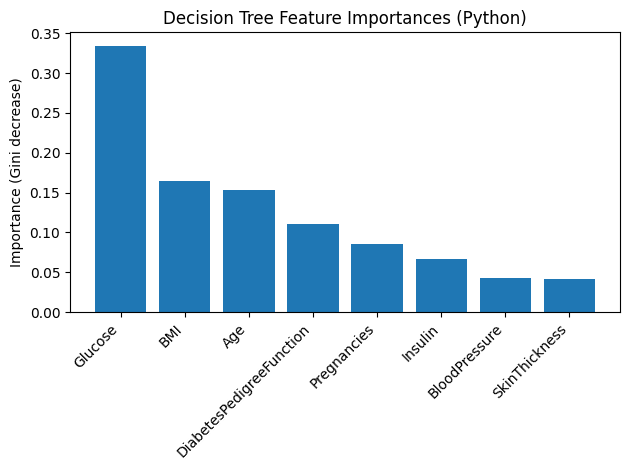

,feature,importance
1,Glucose,0.334287
5,BMI,0.164788
7,Age,0.152754
6,DiabetesPedigreeFunction,0.111133
0,Pregnancies,0.086098
4,Insulin,0.066462
2,BloodPressure,0.043099
3,SkinThickness,0.041378


In [21]:
importances = tree_clf.feature_importances_
fi_df = pd.DataFrame({"feature": feature_cols, "importance": importances}).sort_values(
    "importance", ascending=False
)

plt.figure()
plt.bar(fi_df["feature"], fi_df["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance (Gini decrease)")
plt.title("Decision Tree Feature Importances (Python)")
plt.tight_layout()
plt.show()

fi_df


### Optional: Use Decision Tree PMML exported from KNIME

This part corresponds to the **PMML Writer** + **PMML Reader** + **Decision Tree Predictor** nodes.

Please make sure that the **d-tree.pmml** is uploaded/saved next to the notebook.iypnb.


In [22]:
tree_pmml_path = f"{DATA_DIR}/d-tree.pmml"
tree_pmml_model = PMMLModel.load(tree_pmml_path)

tree_pmml_pred = tree_pmml_model.predict(X_test_scaled)
tree_pmml_pred_with_y = pd.concat(
    [y_test.reset_index(drop=True), tree_pmml_pred.reset_index(drop=True)],
    axis=1,
)

print(tree_pmml_pred_with_y.columns.tolist())

pred_col = (
    "predicted_Outcome"
    if "predicted_Outcome" in tree_pmml_pred_with_y.columns
    else tree_pmml_pred_with_y.columns[0]
)
prob1_col = None
for c in tree_pmml_pred_with_y.columns:
    if "prob" in c.lower() and ("(1)" in c or c.endswith("1")):
        prob1_col = c
        break

tree_pmml_metrics = evaluate_classifier(
    y_true=tree_pmml_pred_with_y["Outcome"],
    y_pred=tree_pmml_pred_with_y[pred_col],
    y_prob=(
        tree_pmml_pred_with_y[prob1_col]
        if prob1_col is not None
        else None
    ),
    positive_label=1,
    model_name="Decision Tree (KNIME PMML in Python)",
)


['Outcome', 'predicted_Outcome', 'probability', 'probability_1', 'probability_0', 'node_id']

=== Evaluation for Decision Tree (KNIME PMML in Python) ===
Label distribution:
  y_true:
Outcome
0    150
1     81
Name: count, dtype: int64

  y_pred:
predicted_Outcome
0    160
1     71
Name: count, dtype: int64

Accuracy: 0.810

Confusion matrix (rows=true, cols=pred) [0,1]:
[[133  17]
 [ 27  54]]

Classification report:
              precision    recall  f1-score   support

           0      0.831     0.887     0.858       150
           1      0.761     0.667     0.711        81

    accuracy                          0.810       231
   macro avg      0.796     0.777     0.784       231
weighted avg      0.806     0.810     0.806       231

ROC AUC (class 1 vs others): 0.841


## 3) Logistic Regression Model and Feature Importances – matches blue block

This section corresponds to:

- **Logistic Regression Learner** – train LR on standardized features
- **Logistic Regression Predictor** – apply LR to the test set
- **PMML Writer** – export the LR model to PMML
- **Global Feature Importance** – interpret the model


In [23]:
logreg_clf = LogisticRegression(max_iter=1000)
logreg_clf.fit(X_train_scaled, y_train)

logreg_pred_test = logreg_clf.predict(X_test_scaled)
logreg_prob_test = logreg_clf.predict_proba(X_test_scaled)[:, 1]

logreg_metrics = evaluate_classifier(
    y_true=y_test,
    y_pred=logreg_pred_test,
    y_prob=logreg_prob_test,
    positive_label=1,
    model_name="Logistic Regression (Python)",
)



=== Evaluation for Logistic Regression (Python) ===
Label distribution:
  y_true:
Outcome
0    150
1     81
Name: count, dtype: int64

  y_pred:
0    166
1     65
Name: count, dtype: int64

Accuracy: 0.740

Confusion matrix (rows=true, cols=pred) [0,1]:
[[128  22]
 [ 38  43]]

Classification report:
              precision    recall  f1-score   support

           0      0.771     0.853     0.810       150
           1      0.662     0.531     0.589        81

    accuracy                          0.740       231
   macro avg      0.716     0.692     0.700       231
weighted avg      0.733     0.740     0.733       231

ROC AUC (class 1 vs others): 0.836


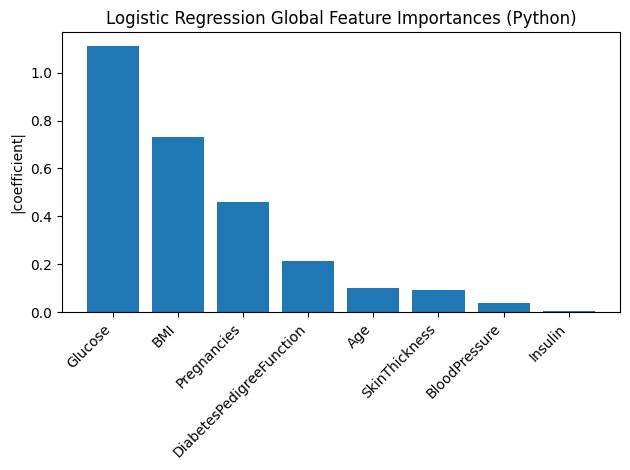

,feature,coefficient,abs_importance
1,Glucose,1.112525,1.112525
5,BMI,0.729765,0.729765
0,Pregnancies,0.459508,0.459508
6,DiabetesPedigreeFunction,0.212772,0.212772
7,Age,0.101926,0.101926
3,SkinThickness,-0.093486,0.093486
2,BloodPressure,-0.038686,0.038686
4,Insulin,0.003051,0.003051


In [24]:
coef = logreg_clf.coef_[0]
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coef,
    "abs_importance": np.abs(coef),
}).sort_values("abs_importance", ascending=False)

plt.figure()
plt.bar(coef_df["feature"], coef_df["abs_importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("|coefficient|")
plt.title("Logistic Regression Global Feature Importances (Python)")
plt.tight_layout()
plt.show()

coef_df


Python equivalent of KNIME "Global Feature Importance"

Permutation Global Feature Importances (Python):


,feature,mean_importance,std_importance
1,Glucose,0.266568,0.049184
5,BMI,0.014864,0.006670
0,Pregnancies,0.004683,0.001979
7,Age,0.003366,0.001874
6,DiabetesPedigreeFunction,0.000255,0.000158
2,BloodPressure,-0.000420,0.000779
4,Insulin,-0.000477,0.000282
3,SkinThickness,-0.002840,0.000950


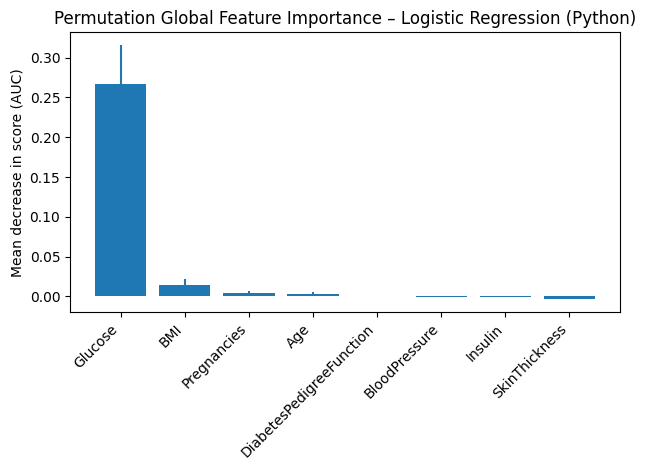

In [25]:
def compute_permutation_global_importance(
    model,
    X,
    y,
    feature_names,
    scoring="roc_auc",
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
):
    result = permutation_importance(
        model,
        X,
        y,
        scoring=scoring,
        n_repeats=n_repeats,
        random_state=random_state,
        n_jobs=n_jobs,
    )

    fi_df = pd.DataFrame(
        {
            "feature": feature_names,
            "mean_importance": result.importances_mean,
            "std_importance": result.importances_std,
        }
    ).sort_values("mean_importance", ascending=False)

    return fi_df

fi_pfi_df = compute_permutation_global_importance(
    model=logreg_clf,
    X=X_test,
    y=y_test,
    feature_names=feature_cols,
)

print("Permutation Global Feature Importances (Python):")
display(fi_pfi_df)

plt.figure()
plt.bar(fi_pfi_df["feature"], fi_pfi_df["mean_importance"])
plt.errorbar(
    fi_pfi_df["feature"],
    fi_pfi_df["mean_importance"],
    yerr=fi_pfi_df["std_importance"],
    fmt="none",
)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean decrease in score (AUC)")
plt.title("Permutation Global Feature Importance – Logistic Regression (Python)")
plt.tight_layout()
plt.show()